In [2]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import numpy as np
import pandas as pd
import os, sys
import scTRS.data_loader as dl
import pandas as pd
import numpy as np
from os.path import join
from statsmodels.stats.multitest import multipletests
import yaml
from scipy.stats import pearsonr

sys.path.append("/n/home12/khou/holystore/")
import paper_utils

import glob
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import combine_pvalues
from tqdm import tqdm

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


celltype x traits matrices for 
1. scDRS
2. LDSC-SEG
3. LDSC-SEG relative
4. MAGMA relative
5. (LDSC-SEG + MAGMA) relative

# Compile results

In [4]:
trait_list = pd.read_csv(
    "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/supp_table.rv1/trait_info.tsv",
    sep="\t",
)["Trait_Identifier"].values

In [49]:
dict_df_pval = dict()

# scDRS
dict_df_pval["scDRS"] = pd.read_csv(
    "data/summary_ct/df_pval.tms_facs.csv", index_col=0
).loc[trait_list, :]

# LDSC-SEG
# result_dir = (
#     "/n/holystore01/LABS/price_lab/Users/khou/scDRS-public/experiments/job.celltype_association/"
#     "01_calc_ldsc/out/tms_facs/cts_result"
# )
result_dir = (
    "/n/holystore01/LABS/price_lab/Users/khou/scDRS-revision/experiments/job.celltype_association.rv1/"
    "03_bryois/out/OLD/cts_result"
)

df_pval = pd.DataFrame(
    index=dict_df_pval["scDRS"].index, columns=dict_df_pval["scDRS"].columns
)
for trait in df_pval.index:
    rls = pd.read_csv(
        join(result_dir, f"{trait}.cell_type_results.txt"),
        sep="\t",
    )
    df_pval.loc[trait, :] = rls.set_index("Name").reindex(df_pval.columns)[
        "Coefficient_P_value"
    ]

dict_df_pval["LDSC"] = df_pval.astype(float)

# LDSC-SEG relative
result_dir = (
    "/n/holystore01/LABS/price_lab/Users/khou/scDRS-revision/experiments/job.celltype_association.rv1/"
    "03_bryois/out/bryois/cts_result"
)
df_pval = pd.DataFrame(
    index=dict_df_pval["scDRS"].index, columns=dict_df_pval["scDRS"].columns
)
for trait in df_pval.index:
    rls = pd.read_csv(
        join(result_dir, f"{trait}.cell_type_results.txt"),
        sep="\t",
    )
    df_pval.loc[trait, :] = rls.set_index("Name").reindex(df_pval.columns)[
        "Coefficient_P_value"
    ]

dict_df_pval["LDSC-specificity"] = df_pval.astype(float)

# MAGMA relative
result_dir = (
    "/n/holystore01/LABS/price_lab/Users/khou/scDRS-revision/experiments/job.celltype_association.rv1/"
    "03_bryois/out/bryois/magma_result"
)
df_pval = pd.DataFrame(
    index=dict_df_pval["scDRS"].index, columns=dict_df_pval["scDRS"].columns
)
for trait in df_pval.index:
    rls = pd.read_csv(
        join(result_dir, f"{trait}.gsa.out"), delim_whitespace=True, comment="#"
    )
    df_pval.loc[trait, :] = rls.set_index("FULL_NAME").reindex(df_pval.columns)["P"]
dict_df_pval["MAGMA-specificity"] = df_pval.astype(float)

# dict_df_pval["MAGMA+LDSC-specificity"] = np.exp(
#     np.log(dict_df_pval["LDSC-specificity"])
#     + np.log(dict_df_pval["MAGMA-specificity"]) / 2
# )

df_tmp = pd.DataFrame(index=df_pval.index, columns=df_pval.columns)
for i in tqdm(range(df_tmp.shape[0])):
    for j in range(df_tmp.shape[1]):
        df_tmp.iloc[i, j] = combine_pvalues(
            [
                dict_df_pval["LDSC-specificity"].iloc[i, j],
                dict_df_pval["MAGMA-specificity"].iloc[i, j],
            ],
            method="fisher",
        )[1]
dict_df_pval["MAGMA+LDSC-specificity"] = df_tmp.astype(float)

# filter for NaN cell-types
ct_list = dict_df_pval["LDSC"].columns[~np.any(np.isnan(dict_df_pval["LDSC"]), axis=0)]
for m in dict_df_pval:
    dict_df_pval[m] = dict_df_pval[m][ct_list]

100%|██████████| 74/74 [00:02<00:00, 35.66it/s]


In [51]:
dict_nlogp = dict()
dict_nlogp["scDRS ~ LDSC"] = (
    -np.log10(dict_df_pval["scDRS"].values.flatten()),
    -np.log10(dict_df_pval["LDSC"].values.flatten()),
)
dict_nlogp["scDRS ~ LDSC-specificity"] = (
    -np.log10(dict_df_pval["scDRS"].values.flatten()),
    -np.log10(dict_df_pval["LDSC-specificity"].values.flatten()),
)
dict_nlogp["scDRS ~ MAGMA-specificity"] = (
    -np.log10(dict_df_pval["scDRS"].values.flatten()),
    -np.log10(dict_df_pval["MAGMA-specificity"].values.flatten()),
)

# dict_nlogp["scDRS ~ MAGMA+LDSC-specificity"] = (
#     -np.log10(dict_df_pval["scDRS"].values.flatten()),
#     -np.log10(dict_df_pval["MAGMA+LDSC-specificity"].values.flatten()),
# )

dict_nlogp["scDRS ~ MAGMA+LDSC-specificity"] = (
    -np.log10(dict_df_pval["scDRS"].values.flatten()),
    -np.log10(dict_df_pval["MAGMA+LDSC-specificity"].values.flatten()),
)

#     -np.log10(dict_df_pval["MAGMA-specificity"].values.flatten())
#     - np.log10(dict_df_pval["LDSC-specificity"].values.flatten())

for label in dict_nlogp:
    nlogp1, nlogp2 = dict_nlogp[label]
    print(f"{label}: {pearsonr(nlogp1, nlogp2)[0]:.2g}")

scDRS ~ LDSC: 0.66
scDRS ~ LDSC-specificity: 0.68
scDRS ~ MAGMA-specificity: 0.63
scDRS ~ MAGMA+LDSC-specificity: 0.68


In [52]:
dict_df_fdr = dict()
for m in dict_df_pval:
    dict_df_fdr[m] = pd.DataFrame(
        multipletests(dict_df_pval[m].values.flatten(), method="fdr_bh")[1].reshape(
            dict_df_pval[m].shape
        ),
        index=dict_df_pval[m].index,
        columns=dict_df_pval[m].columns,
    )
list_numerical_pairs = [
    ("UKB_460K.bmd_HEEL_TSCOREz", "pancreatic_PP_cell"),
    ("PASS_Multiple_sclerosis", "granulocyte_monocyte_progenitor_cell"),
    ("PASS_MDD_Howard2019", "oligodendrocyte_precursor_cell"),
]
for pair in list_numerical_pairs:
    for m in dict_df_fdr:
        print(
            f"{m} FDR: ({pair[0]}, {pair[1]}), {dict_df_fdr[m].loc[pair[0], pair[1]]}"
        )
    print()

scDRS FDR: (UKB_460K.bmd_HEEL_TSCOREz, pancreatic_PP_cell), 0.06382107101531569
LDSC FDR: (UKB_460K.bmd_HEEL_TSCOREz, pancreatic_PP_cell), 0.9999998642301584
LDSC-specificity FDR: (UKB_460K.bmd_HEEL_TSCOREz, pancreatic_PP_cell), 0.9999999521966538
MAGMA-specificity FDR: (UKB_460K.bmd_HEEL_TSCOREz, pancreatic_PP_cell), 1.0
MAGMA+LDSC-specificity FDR: (UKB_460K.bmd_HEEL_TSCOREz, pancreatic_PP_cell), 0.9999999999956314

scDRS FDR: (PASS_Multiple_sclerosis, granulocyte_monocyte_progenitor_cell), 0.01928506276332172
LDSC FDR: (PASS_Multiple_sclerosis, granulocyte_monocyte_progenitor_cell), 0.30571093753408723
LDSC-specificity FDR: (PASS_Multiple_sclerosis, granulocyte_monocyte_progenitor_cell), 0.5213222671847542
MAGMA-specificity FDR: (PASS_Multiple_sclerosis, granulocyte_monocyte_progenitor_cell), 0.5785986254295533
MAGMA+LDSC-specificity FDR: (PASS_Multiple_sclerosis, granulocyte_monocyte_progenitor_cell), 0.39026271442243005

scDRS FDR: (PASS_MDD_Howard2019, oligodendrocyte_precursor_ce

In [53]:
signif_mask = []
for method in dict_df_pval:
    signif_mask.append(
        multipletests(
            dict_df_pval[method].reset_index().melt("index")["value"],
            alpha=0.05,
            method="fdr_bh",
        )[0]
    )
signif_mask = np.array(signif_mask).sum(axis=0)

In [56]:
from scipy.stats import fisher_exact

In [59]:
def fisher_test(index1, index2):
    contingency_tbl = np.zeros((2, 2))

    assert len(index1) == len(index2)
    s1 = set(np.where(index1)[0])
    s2 = set(np.where(index2)[0])
    contingency_tbl[1, 0] = len(s2 - s1)
    contingency_tbl[0, 1] = len(s1 - s2)
    contingency_tbl[1, 1] = len(s1 & s2)
    contingency_tbl[0, 0] = (
        len(index1)
        - contingency_tbl[1, 0]
        - contingency_tbl[0, 1]
        - contingency_tbl[1, 1]
    )

    return fisher_exact(contingency_tbl)

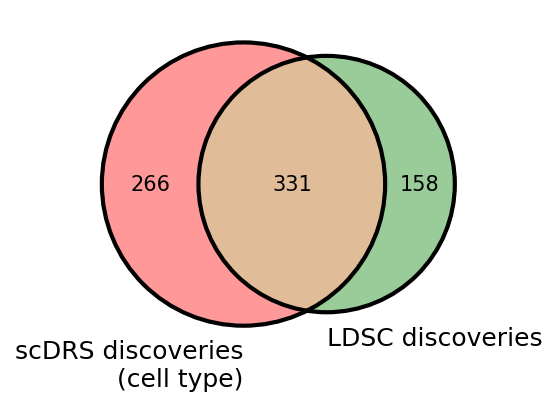

scDRS LDSC (63.99007804320929, 2.929905177053303e-306)
Pearson's r between scDRS and LDSC: 0.66


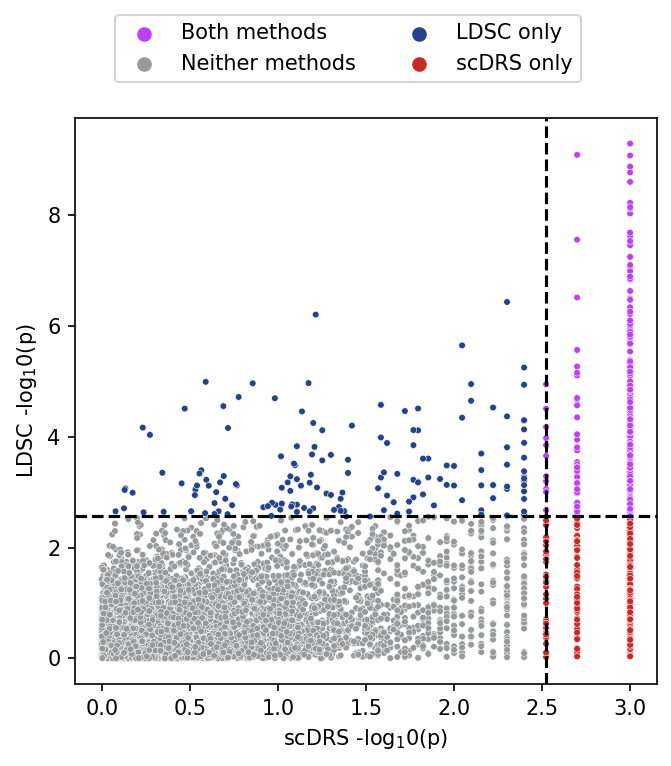

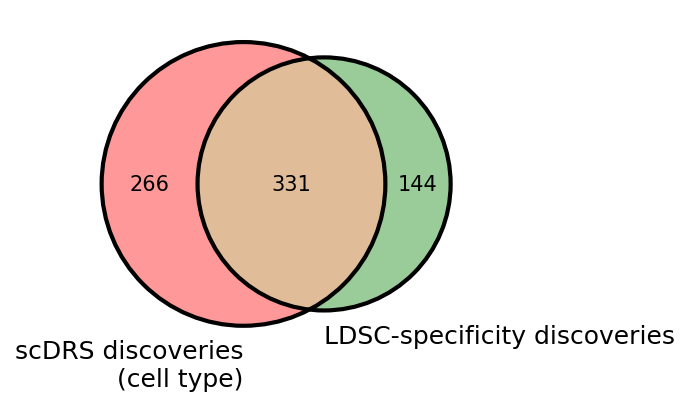

scDRS LDSC-specificity (70.33231516290726, 4.1380390894e-313)
Pearson's r between scDRS and LDSC-specificity: 0.68


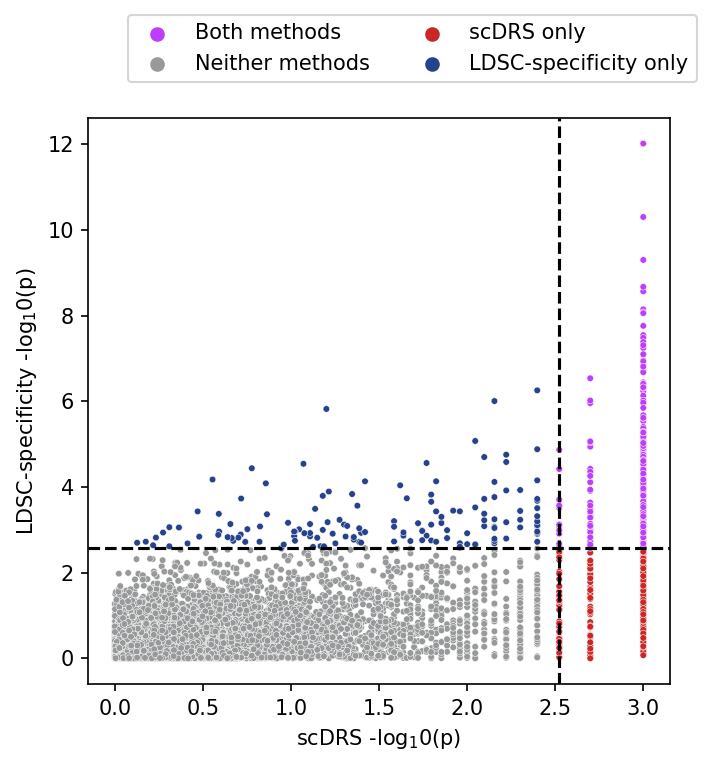

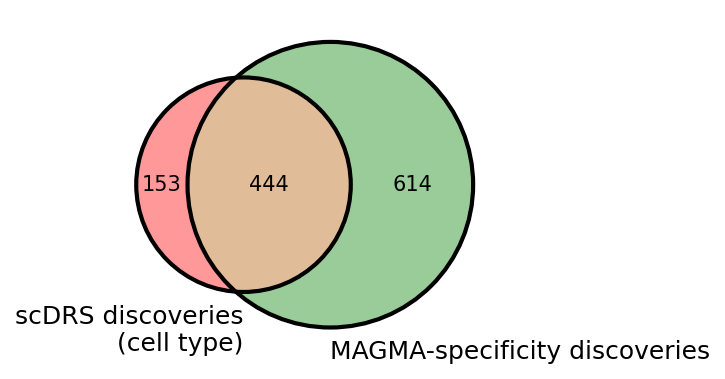

scDRS MAGMA-specificity (36.24615188094782, 1.36502580374e-312)
Pearson's r between scDRS and MAGMA-specificity: 0.63


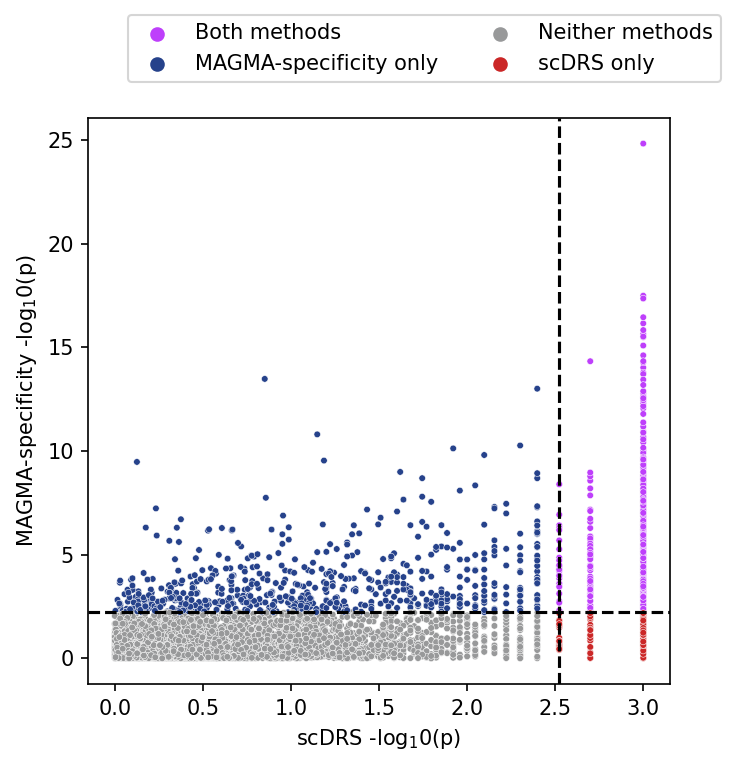

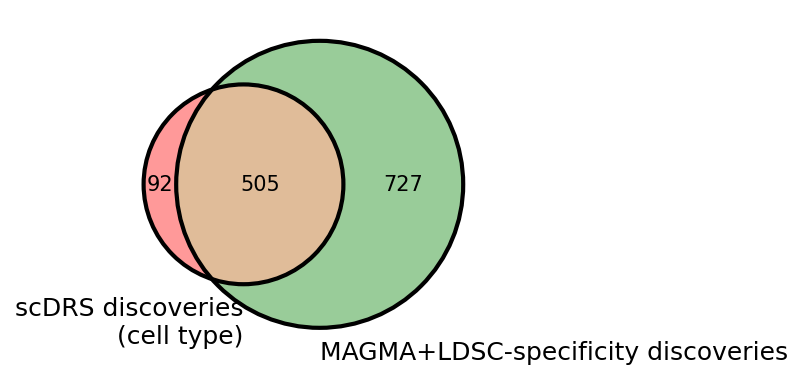

scDRS MAGMA+LDSC-specificity (57.05071467017523, 0.0)
Pearson's r between scDRS and MAGMA+LDSC-specificity: 0.68


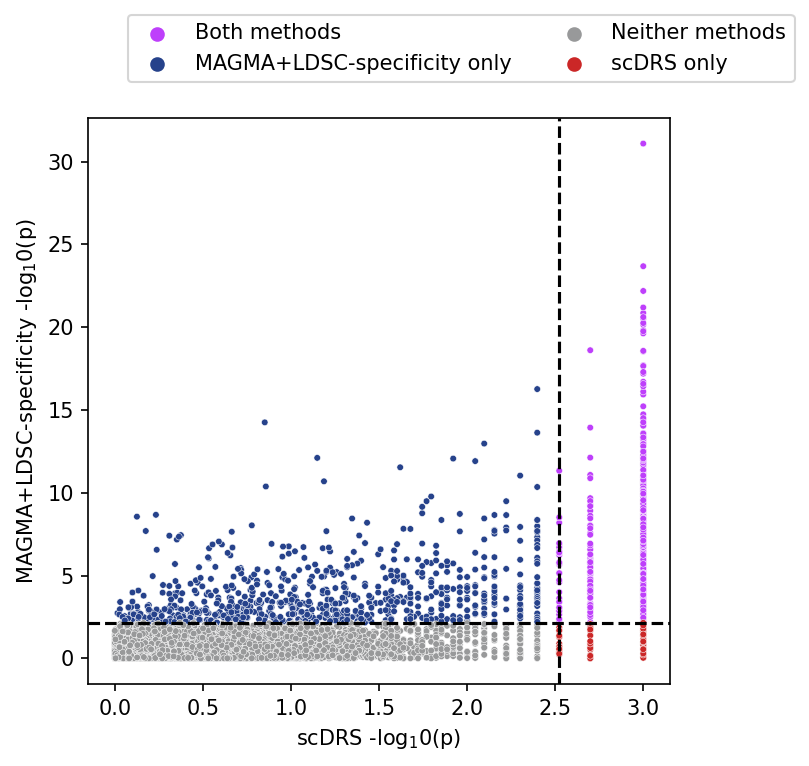

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

for method1, method2 in [
    ("scDRS", "LDSC"),
    ("scDRS", "LDSC-specificity"),
    ("scDRS", "MAGMA-specificity"),
    ("scDRS", "MAGMA+LDSC-specificity"),
]:
    melted_df1 = dict_df_pval[method1].reset_index().melt("index")
    melted_df1.columns = ["trait", "ct", "nlog10p1"]
    melted_df2 = dict_df_pval[method2].reset_index().melt("index")
    melted_df2.columns = ["trait", "ct", "nlog10p2"]

    join_df = pd.merge(
        melted_df1,
        melted_df2,
        on=["trait", "ct"],
    )
    join_df["nlog10p1"] = -np.log10(join_df["nlog10p1"])
    join_df["nlog10p2"] = -np.log10(join_df["nlog10p2"])

    signif_mask1 = multipletests(
        np.power(10, -join_df.nlog10p1), alpha=0.05, method="fdr_bh"
    )[0]

    signif_mask2 = multipletests(
        np.power(10, -join_df.nlog10p2), alpha=0.05, method="fdr_bh"
    )[0]

    from matplotlib_venn import venn2, venn2_circles
    from scipy.stats import fisher_exact

    plt.figure(figsize=(6, 3), dpi=150)
    signif_index1 = np.where(signif_mask1)[0]
    signif_index2 = np.where(signif_mask2)[0]

    v = venn2(
        [set(signif_index1), set(signif_index2)],
        set_labels=(
            f"{method1} discoveries\n(cell type)",
            f"{method2} discoveries",
        ),
    )
    c = venn2_circles([set(signif_index1), set(signif_index2)])
    plt.savefig(f"results/methods_compare_{method1}_{method2}.pdf", bbox_inches="tight")

    plt.show()

    contingency_tbl = np.zeros((2, 2))
    contingency_tbl[1, 0] = len(set(signif_index1) - set(signif_index2))
    contingency_tbl[0, 1] = len(set(signif_index2) - set(signif_index1))
    contingency_tbl[1, 1] = len(set(signif_index1) & set(signif_index2))
    contingency_tbl[0, 0] = (
        join_df.shape[0]
        - contingency_tbl[1, 0]
        - contingency_tbl[0, 1]
        - contingency_tbl[1, 1]
    )
    print(method1, method2, fisher_exact(contingency_tbl))
    # print(contingency_tbl)
    join_df.loc[signif_mask1 & signif_mask2, "label"] = "Both methods"
    join_df.loc[signif_mask1 & (~signif_mask2), "label"] = f"{method1} only"
    join_df.loc[(~signif_mask1) & signif_mask2, "label"] = f"{method2} only"
    join_df.loc[(~signif_mask1) & (~signif_mask2), "label"] = "Neither methods"

    plt.figure(figsize=(5, 5), dpi=150)
    sns.scatterplot(
        data=join_df,
        x="nlog10p1",
        y="nlog10p2",
        hue="label",
        s=10,
        palette={
            f"{method1} only": "#cb2727",
            f"{method2} only": "#26428b",
            "Both methods": "#be3ffb",
            "Neither methods": "#98999a",
        },
        alpha=1.0,
    )
    plt.xlabel(f"{method1} -log$_{10}$(p)")
    plt.ylabel(f"{method2} -log$_{10}$(p)")
    plt.axvline(x=join_df.loc[signif_index1, "nlog10p1"].min(), color="black", ls="--")
    plt.axhline(y=join_df.loc[signif_index2, "nlog10p2"].min(), color="black", ls="--")
    plt.legend(bbox_to_anchor=(0.05, 1.2), loc="upper left", ncol=2)
    print(
        f"Pearson's r between {method1} and {method2}: {pearsonr(join_df.nlog10p1.values, join_df.nlog10p2.values)[0]:.2g}",
    )
    plt.show()

In [8]:
assert False

AssertionError: 

# Visualize different results

In [15]:
# Plot order for main figure
URL_SUPP_TABLE = "/n/holystore01/LABS/price_lab/Users/khou/scDRS-revision/experiments/job.celltype_association.rv1/supp_tables.xlsx"

df_trait_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=0,
)

df_celltype_info = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name=1,
)

df_tmp = pd.read_excel(
    URL_SUPP_TABLE,
    sheet_name="fig3-display",
).dropna(how="all")

plot_order = dict()
for c, group in df_tmp.groupby("cluster"):
    plot_order[c] = (group.trait.dropna().values, group.celltype.dropna().values)

dict_trait_name = {
    row.Trait_Identifier: row["Code"] for _, row in df_trait_info.iterrows()
}

dict_celltype_name = {
    row.id: row.code for _, row in df_celltype_info.iterrows() if not pd.isna(row.code)
}


def trait_display_name(x):
    dict_trait_name = {
        row.Trait_Identifier: row["Trait Name"] for _, row in df_trait_info.iterrows()
    }
    dict_trait_code = {
        row.Trait_Identifier: row["Code"] for _, row in df_trait_info.iterrows()
    }

    if dict_trait_name[x].lower() != dict_trait_code[x].lower():
        display_name = f"{dict_trait_name[x]} ({dict_trait_code[x]})"
    else:
        display_name = dict_trait_name[x]

    # special case for RDW
    if dict_trait_code[x] == "RDW":
        return "RBC Distribution width (RDW)"
    return display_name


def celltype_display_name(x):
    if x in dict_celltype_name:
        name = dict_celltype_name[x]
    else:
        name = x
    name = name.replace("_", " ")
    name = name[0].upper() + name[1:]
    return name

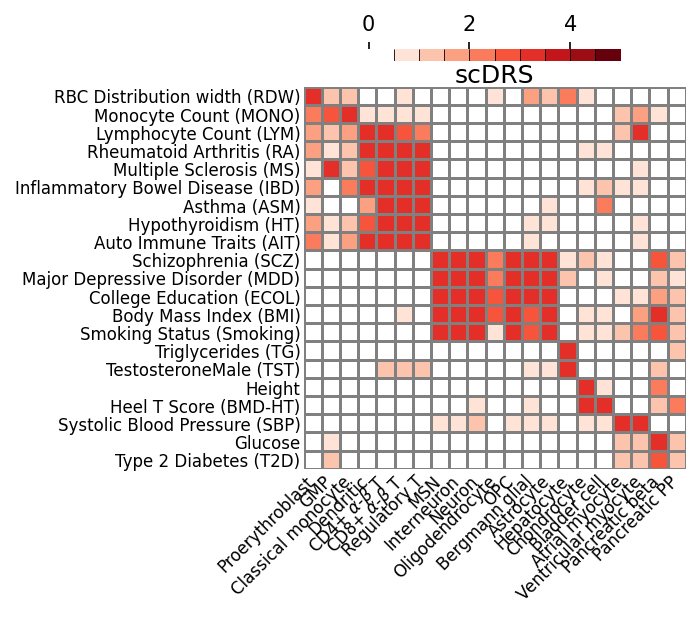

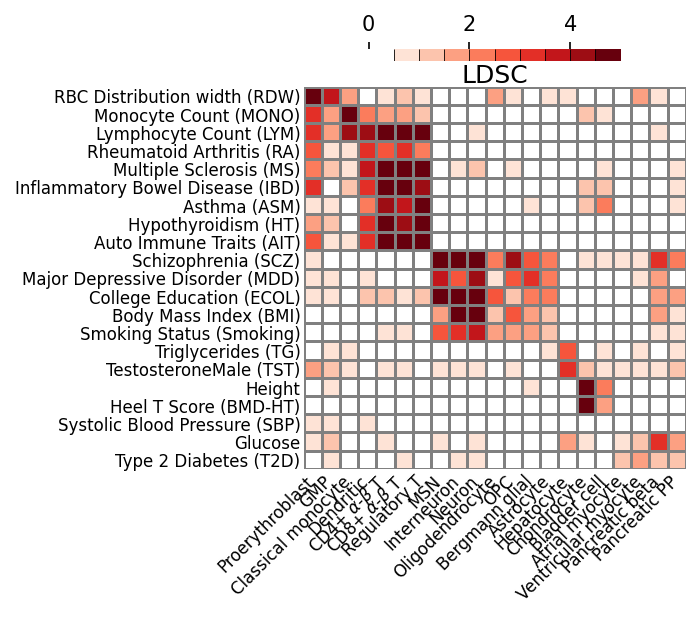

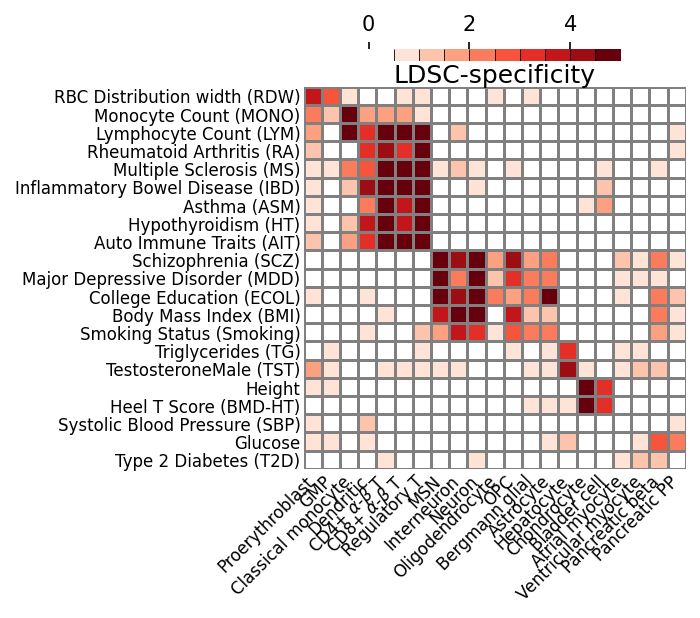

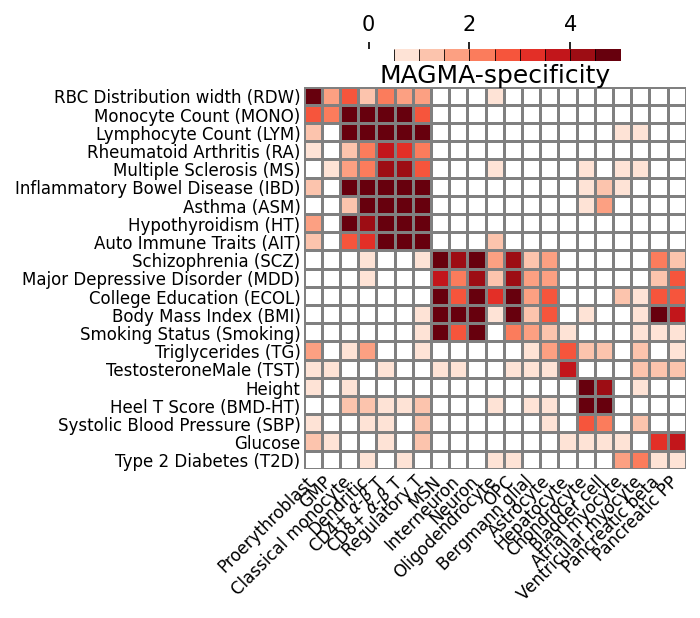

In [16]:
for method in dict_df_pval:
    df_plot = (
        dict_df_pval[method]
        .loc[
            np.concatenate([plot_order[c][0] for c in plot_order]),
            np.concatenate([plot_order[c][1] for c in plot_order]),
        ]
        .copy()
    )
    df_plot = -np.log10(df_plot)
    df_plot = df_plot.rename(index=trait_display_name, columns=celltype_display_name)

    fig, ax = paper_utils.plot_heatmap(
        df_plot,
        squaresize=20,
        heatmap_annot_kws={"color": "black", "size": 4},
        heatmap_cbar_kws=dict(
            use_gridspec=False, location="top", fraction=0.03, pad=0.06, drawedges=True
        ),
        heatmap_vmin=0,
        heatmap_vmax=5 if method == "scDRS" else 5,
        colormap_n_bin=10,
    )
    ax.set_title(method, y=0.98)